In [ ]:
!pip install --upgrade pandas trackpy noctiluca bayesmsd

In [ ]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

from pathlib import Path
import io
import itertools
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import trackpy
from matplotlib import pyplot as plt

import noctiluca as nl
import bayesmsd

# Intro

As a relatively straight-forward example of live-cell imaging data, we study the dynamics of the chromatin fiber. Our "virtual collaborator" engineered a U2OS cell line where histone H2B is (sparsely) labelled with a fluorescent marker. Imaging their cells under a fluorescent microscope, they got a few nice movies that might look something like this:
<div>
<img src="graphics/movie_gif.gif" width="300" alt="animation of the original movie"/>
</div>
<font size="1">
Movie acquired by SGH, Coulon lab @ Institute Curie, 2022
</font>

**Cool! What and how do we learn from this?**

In dealing with data like the movie above, we usually follow a three step procedure:
+ **localize** individual fluorophores in the movie
+ **link** localizations from different frames together in coherent trajectories
+ **analyze** those trajectories to understand the underlying physics/biology

This workshop will lead you through each of these three steps in order. Let's get into it!

# Localizing fluorescent spots

![raw movie frame](graphics/localize0.png)
![movie frame with localizations](graphics/localize1.png)

The goal of this section is illustrated by the stills above: identify the locations of the individual fluorescent markers in each frame of our movie. For this workshop, we will use the ImageJ plug-in "ThunderSTORM", which takes a physics-minded approach to this task and is thus very well suited for single molecule experiments.

### Software

This section of the tutorial relies on software running locally on your machine. We will use
+ [Fiji/ImageJ: the de facto standard image processing tool in life sciences](https://imagej.net/software/fiji/downloads)
+ [ThunderSTORM: a plug-in for particle localization](https://zitmen.github.io/thunderstorm/)

#### Installation instructions (please do this before the workshop!)

+ **download Fiji**: go to the Fiji website linked above and download the right version for your OS. This will be a zip-compressed folder.
  - **extract** the folder to a location in your user space (e.g. under Windows the recommended location is `C:\Users\<your user>\Fiji`; note that the website warns against installing to `C:\Program Files`, since Fiji might not have write permissions there). We will assume that you chose the location `<path>\Fiji`.
  - **locate Fiji's plug-in folder**; it should be at `<path>\Fiji\Fiji.app\plugins`. It should already contain a whole library of `.jar` files
+ go to the link for ThunderSTORM; click the "download ThunderSTORM" button on the top left. You will be redirected to GitHub.
  - **download the file `Thunder_STORM.jar`** and
  - **place it in Fiji's plug-in folder**
+ **start Fiji** by running the executable found in `<path>\Fiji\Fiji.app`. On Windows, it is called `ImageJ-win64.exe` (not "Fiji"!)
  - check that the menu `Plugins > ThunderSTORM` exists
+ create a new directory somewhere in your user space, which we will use as working directory for this tutorial. Place the tutorial data (`localization_demo_U2OS_H2B_JF549.tif`) in this directory.

## Open the movie

You can drag-and-drop the movie (`localization_demo_U2OS_H2B_JF549.tif`) into Fiji; alternatively, use `File > Open` or `Ctrl-O`. Once the movie pops up, you can press the `+`/`-` keys to grow/shrink the window as you like. You will probably want to adjust the contrast a little, so go to `Image > Adjust > Brightness/Contrast` (or `Ctrl-Shift-C`) to bring up the corresponding dialog. You can play with the settings, or just hit the `Auto` button, which usually gives a decent picture. Note that we are only adjusting the visualization, we are not changing the data in the movie!

You can use the slider on the bottom to scroll through the movie and get a first impression of what your data actually looks like.

### Two short exercises to familiarize yourself with Fiji and our movie

**Task 1**: Can you measure the pixel size?

![A line at the bottom of the Fiji window gives live info about the current cursor position](graphics/values.png)

At the bottom of the main window, you have a readout of your current cursor position in the movie. `x` and `y` coordinates are given in μm (pixels).

Zoom in or out of the image with the `+`/`-` keys until you can clearly see individual pixels. Use the reported absolute positions of a few adjacent pixels to estimate the pixel size in μm. The code below might be useful.

In [ ]:
locations = [15.83, 15.96, ...]
pixelsize_um = np.mean(np.diff(locations))
print(f"Hand-estimated pixel size:     {pixelsize_um:.4f} μm")
print( "True pixel size in this movie: 0.1287 μm")

**Task 2**: How wide is a point-spread function?

The spots you see in the movie are (for the most part) single fluorescent molecules. However, due to the wave nature of light, they appear not as single points (or pixels), but as finite size "blobs". This blob is called a "point spread function (PSF)" and determines the minimum distance that two particles must have, such that we can still distinguish them; this is known as the *diffraction limit*.

Look at a few of the spots in the movie; what would you say is their average diameter (in pixels)? What is that in μm?

In [ ]:
diameter_px = ...
diameter_um = diameter_px * pixelsize_um
print(f"PSF Diameter: {diameter_um:.3f} μm")
print(f"PSF Radius:     {500*diameter_um:.0f} nm")

**Task 3**: Emission wave length from PSF

We expect the PSF to have a diameter of $d = \lambda/\mathrm{NA}$, where the "numerical aperture" $\mathrm{NA}$ is a characteristic of the microscope objective; for our example movie, $\mathrm{NA} = 1.4$. Can you estimate the emission wave length $\lambda$ of the fluorophore? Can you tell how good your estimate is?

<font size="1">
Hint: the fluorophore is called "JF549"
</font>

In [ ]:
NA = 1.4
wavelength_nm = 1e3 * diameter_um * NA
print(f"Estimated emission wavelength: {wavelength_nm:.0f} nm")

## Set up for spot detection

![The freehand selection tool in Fiji GUI](graphics/roi_selector.png)

Our movie contains some fluorescent accumulation outside the nucleus, which we would like to exclude from the localization procedure. Use the freehand selection tool to draw an ROI ("region of interest") around the nucleus. Once you have your ROI, you can scroll through the movie to check that the nucleus does not leave this region over the course of the movie.

![An example ROI](graphics/roi.png)

Start ThunderSTORM through the Fiji menu `Plugins > ThunderSTORM > Run analysis`. In the dialog that appears, click on <button>Camera setup</button> at the top and enter the following values:

![ThunderSTORM camera settings:  Pixel size [nm] = 128.7  ||  Photoelectrons per A/D count = 8  ||  Base level [A/D counts] = 450  ||  EM gain = 30](graphics/camera_setup.png)

These parameters allow ThunderSTORM to work in physical units: nanometers and photon count.

The latter, in fact, we rarely really use; setting the associated parameters (i.e. everything beyond pixel size) to wrong values therefore [is not a big issue](https://github.com/zitmen/thunderstorm/wiki/Guidelines-for-the-choice-of-parameters#camera) and it would also be fine to leave them at their default value (unless you want to analyze e.g. the localization uncertainty reported by ThunderSTORM; we will come back to this in the Analysis section of the workshop).

Finally, enter the following settings in the main ThunderSTORM dialog:

![ThunderSTORM localization setup  ||  Wavelet filter, order=3, scale=2.0  ||  Local maximum in 8-neighborhood, peak intensity threshold = 2.0*std(Wave.F1)  ||  PSF: Integrated Gaussian (weighted least squares), fitting radius=3px, initial sigma=1.0, no multi-emitter fitting  ||  No Renderer](graphics/thunderstorm_setup.png)

You can hit <button>Preview</button> at the bottom to check where you would localize particles in the current frame of the movie with these settings. This is generally useful to tune the different parameters a little bit to your specific data.

ThunderSTORM takes a three-step approach to finding particle coordinates in a frame:
+ **filter the image** to suppress noise and make "PSF-sized" structures stand out; note that this requires knowing what "PSF-sized" means. This is encoded in the parameters given to the different methods available for this step. The filtered image pops up along with the localizations when you generate the preview.
+ **identify particle candidates** in the filtered image. The filtering suppresses noise, so now we can just search for local maxima as our candidates for each particle.
+ **refine the position estimate** from the raw data. Now that we have candidates for our particle locations, we can locally optimize the position estimates. Generally there are two approaches: fit the PSF, or simply determine the centroid of the candidate "blob". Generally speaking, fitting PSFs is appropriate only for diffraction limited (i.e. small) probes such as single molecules, while for larger probes (such as fluorescent arrays) one should switch to centroid localization.

**Task 4**: the "Peak intensity threshold" parameter in the "Approximate localization of molecules" step controls the prominence over background that a spot needs to have to be detected as a candidate for localization. Vary the numerical prefactor and observe the effect on the localizations you get in Preview. Can you determine a reasonable setting for this parameter?

## Find all spots!

When you are happy with the parameter settings, hit <button>Ok</button> on the ThunderSTORM configuration dialog to run the spot detection on the whole movie (*if a log window pops up complaining about the camera base level, it can just be ignored and/or closed*). You should get a table with all the localizations; simultaneously, the localizations will be overlaid on the movie, so you can also scroll through there to check how well we did.

![Table with ThunderSTORM localizations](graphics/localizations.png)

The important columns in this table are
+ **id**: a unique number for each localization
+ **frame**: which frame this localization is in
+ **x**, **y**: the absolute position of this localization
+ **sigma**: the fitted standard deviation of the PSF. Compare these values to the PSF radius (radius, not diameter!) we estimated above.
+ **intensity**: total photon count associated with this localization
+ **offset**: background intensity; should be positive for "real" detections
+ **uncertainty**: the uncertainty that ThunderSTORM associates with this location estimate of the fluorophore. This is a theoretical estimate derived from `sigma` and `intensity`; so if your camera calibration is off, you shouldn't trust this value too much.

Note that there seem to be some outliers, likely wrong localizations. E.g. localization #8 reports a sigma of 635 nm, which is noticeably larger than what we would expect for our single fluorophores. We would thus like to a) identify outliers and then b) filter them out of the data.

**Task 5**: use <button>Plot histogram</button> at the bottom of the dialog to check the distributions of a few parameters; of special interest are `sigma`, `offset` and `uncertainty`. Identify outliers. Then, use the "Filter" tab at the bottom of the window to filter them out. 

Find a good filter criterion to clean up the data set; aim to be rather restrictive than permissive (the logic being that missing good localizations just makes you lose data; including bad localizations makes your data wrong).

*Tip*: The entry in the "Filter" field should be a logical expression using the parameters from the table, e.g. one could write `(x > 8000 y < 12000) | sigma > 300` to filter for only those localizations that are either in the top right corner, OR have a large PSF standard deviation. Once you hit "Apply", the table as well as the overlay on the movie update, so you can see the effect of your filtering. You can also replot histograms to check the effects on the whole data set.

**Solution to Task 5**: if you think you have found a good filter criterion, feel free to use that. If you are unsure, enter the following in the "Filter" line: `sigma < 200 & uncertainty < 30`. Note that we lose quite a few localizations in the first frames of the movie, but reliably keep those that persist for longer times. Also note that upon replotting the histogram for "offset", all the zero-offset localizations are gone; those are usually mislocalizations (which we could also explicitly filter for).

Finally, use the "Remove duplicates" tab to filter out localizations that ended up on the same molecule. Use `sigma` as the threshold.

![Removing duplicates](graphics/duplicates.png)

Note the very bottom line, stating that this step removed 4 out of 5674 localizations; so we did not have many overlaps to start with.

## Save localizations

We're done! Click <button>Export</button> to save the localizations in a `.csv` file in your working directory (if you're using the structure of the git repo, use `./processing`). For this example, I will use the file name `localization_demo_U2OS_H2B_JF549_localizations.csv`. Make sure to check "Save measurement protocol" in the export dialog, which writes a second file containing all the ThunderSTORM settings we used for this localization process; this is essential for reproducibility.

![Exporting localizations from ThunderSTORM. Make sure to check "Save measurement protocol"!](graphics/export.png)

# Linking localizations into trajectories

We now have a file with individual localizations from all frames of our movie.

(*If for some reason you did not complete the previous section, use the provided file* `backup_intermediate_files/localization_demo_U2OS_H2B_JF549_localizations.csv`)

The problem with that file is that it does not tell us which localization in frame $n+1$ belongs to the same particle that we see somewhere in frame $n$; put another way, we have not yet *identified particles across different frames*. This is a non-trivial problem, and it is easy to imagine scenarios where it is impossible to solve: if our tracked particles moved fast enough to cover significant distance over the time between two frames, we might not be able to tell which spot moves where. Fortunately, chromatin is generally quite slow and the labelling density in the movie is low, such that this identification task should be feasible on our data (check by looking at the movie by eye: it is generally quite clear how to connect the dots).

This section of the workshop walks you through one possible approach to linking together trajectories using the `trackpy` library. Note that instead of the GUI-based ThunderSTORM, we now move to coding ourselves.

## Set up

In [ ]:
# `workingdir` should be the directory to work in
# `loc_file`   should point to the ThunderSTORM results
# The rest of this code sets up a few things that will come in handy later and can remain unchanged
workingdir  = Path('./processing')
loc_file    = workingdir / 'localization_demo_U2OS_H2B_JF549_localizations.csv'

# Where to store plot output
plot_folder = workingdir / 'plots'
plot_folder.mkdir(parents=True, exist_ok=True)

# Where to store the final data set
data_file = loc_file.with_suffix('.trajectories.h5')

# Keep track of units
units = {
    'px_nm' : 128.7,
    'px_um' : 0.1287,
    'dt_ms' : 125,
    'dt_s'  : 0.125,
}

# Set up a primitive logging mechanism
# (better: https://docs.python.org/3/howto/logging.html)
linklog_file = loc_file.with_suffix('.linklog.txt')
with open(linklog_file, 'wt') as f:
    f.write(f"Linker logfile for file {str(loc_file.name)}\n")

# Drop-in replacement for print(), to simultaneously write to log
def log(line="", file=linklog_file):
    print(line)
    with open(str(file), 'at') as f:
        f.write(line+'\n')

In [ ]:
# Read the ThunderSTORM localizations into a pandas DataFrame
loc_df = pd.read_csv(loc_file, sep=',')
loc_df.head()

## A few sanity checks
It is always a good idea to confirm that your data conforms to some basic expectations. In this example, we generate two simple plots:
+ we check **which frame gives us how many localizations**; this is a plot we could also have done in ThunderSTORM. Its purpose is simply to get a feel for how many trajectories of what length we should expect. Due to photobleaching we will of course get many more localizations early in the movie.
+ we check for **subpixel localization bias**. ThunderSTORM localizes the fluorophore location with a precision that can be an order of magnitude beyond the pixel size. This is possible because the PSF spans more than one pixel, so we can combine multiple intensities to triangulate the fluorophore more precisely. If this approach works correctly, we expect the measured position of the fluorophore to be independent of its real position relative to the pixel grid. As a quick check, we plot the density of the "subpixel part" of all localizations; we expect to see a homogeneous pattern with some shot noise.

In [ ]:
# Number of localizations per frame
plt.hist(loc_df['frame'], bins=np.arange(loc_df['frame'].max()+1)-0.5, density=False)

plt.xlabel('frame')
plt.ylabel('#localizations')
plt.title('Localizations per frame')

plt.savefig(plot_folder/'loc_per_frame.pdf')
plt.show()

In [ ]:
# Subpixel bias
x = loc_df['x [nm]']/units['px_nm'] % 1 - 0.5
y = loc_df['y [nm]']/units['px_nm'] % 1 - 0.5

bins = (np.linspace(-0.5, 0.5, 15), np.linspace(-0.5, 0.5, 15))
h, _, _ = np.histogram2d(x, y, bins=bins, density=True)

plt.pcolormesh(bins[0], bins[1], h.T,
               cmap='gray',
               vmin=0,
              )
plt.colorbar()
plt.axis('square')
plt.title('Subpixel localization density')

plt.savefig(plot_folder/'subpixel.pdf')
plt.show()

## Linking

Having checked that our data looks reasonable, let's start linking it together into trajectories. The heavy lifting here is done by the `trackpy` library, but the basics are simple (see cartoon): for each localization in frame $n$ we draw a circle around it with a fixed radius. If there is one localization within this circle in frame $n+1$, we link the two together; if there are multiple candidates, we pick the closest one.

<center>
<div>
<img src="graphics/linking_sketch_small.png" alt="Sketch: nearest neighbor linking"/>
</div>
</center>

If there is no point in the next frame, the trajectory ends in frame $n$; which might lead to a lot of trajectories being cut off prematurely. So we relax the condition a little bit, allowing for a few missing frames before a trajectories continues. These missing frames can come about for two reasons:
+ fluorophores blinking: some fluorophores can temporarily switch to a non-fluorescent state, but reappear a little while later
+ missed during localization step: remember that in the localization step we applied quite strong filter criteria; so we might well have filtered out some real spots that would appear as missing frames now.

So, `trackpy` needs two parameters from us: a search radius, and a maximum "memory" span, i.e. for how long fluorophores are allowed to vanish between reappearances. Following the same idea as for the localization filtering above, we will apply rather restrictive criteria.

### Fixing a search range

How far should we allow a fluorophore to move between frames? Well, depends on how fast it moves; *which is one of the questions we aim to answer with our data!* We have a bit of a chicken-and-egg problem here: setting a reasonable search range depends on the dynamics of the molecule under study. In turn, the dynamics we will *observe* in our data, depend on this search range (since by construction steps in the trajectory cannot be larger than this cutoff). We should thus make sure that a) we can justify the choice of search range and b) it does not have a strong impact on the resulting trajectories. Fortunately, we can achieve both.

To find a good search range, we resort to an exhaustive evaluation of the linking problem over one frame. This means: for each localization in each frame, calculate the distances to all localizations in the next frame and find the smallest one. We expect the distribution of these "closest distances" to be bimodal:
+ either the same particle exists in the next frame and has not moved much; or
+ the particle does not exist in the next frame, in which case the "closest distance" will be to some unrelated localization far away.

The code cell below generates this distribution for our localization data; we can clearly identify the two modes and a cutoff between them, which will be our linking distance.

In [ ]:
# Shortest distances between frames
Nframes = int(loc_df['frame'].max())
dists = []
for t in tqdm(range(1, Nframes)):
    df0 = loc_df.loc[loc_df['frame'] == t,   ['x [nm]', 'y [nm]']]
    df1 = loc_df.loc[loc_df['frame'] == t+1, ['x [nm]', 'y [nm]']]

    if len(df0) > 0 and len(df1) > 0:
        all_dx = df0.to_numpy()[:, None, :] - df1.to_numpy()[None, :, :]
        shortest = np.min(np.linalg.norm(all_dx, axis=-1), axis=-1)
        dists.append(shortest)
    
dists = np.concatenate(dists)

plt.figure(figsize=[7, 3])

plt.hist(dists, bins=units['px_nm']*np.logspace(-2.5, 2, 200), density=False)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('frame to frame nearest neighbor distance [nm]')
plt.ylabel('count')
plt.title('Closest distance across adjacent frames')

plt.savefig(plot_folder/'frameframe_distances.pdf')
plt.show()

Cool, this looks quite clear cut! Again, to be on the safe side, we might want to choose a somewhat restrictive setting, e.g. 200 nm instead of the 300 nm that the plot indicates. We expect not much of a difference (which we confirm below).

### Excercise 1: run the linker!

We are now set up to link trajectories! The call to the `trackpy.link()` routine works as shown below. It returns a new data frame with the added column `particle` identifying a trajectory: all localizations with the same `particle` number belong to the same trajectory.

Note that we have not really discussed the value of the `memory` variable yet; what do you think would be a reasonable setting? How would you assess this?

Execute the code below; vary the `memory` setting and assess the impact it has.*

<font size="1">*: purposefully vague statement; get creative!</font>

In [ ]:
df_linked = trackpy.link(loc_df,
                         pos_columns  = ['y [nm]', 'x [nm]'],
                         t_column     = 'frame',
                         search_range = 300,     # search range in nm
                         memory       = 0,       # maximum gap length, in frames
                        )
df_linked.head()

### Running the linker with a few different settings

The code below automates the "just look at a few different settings" approach. The metric we use to asses the impact of the linker settings is the trajectory survival curve, i.e. how many trajectories of what length we get. Run the two code cells below and check the output.

In [ ]:
# Specify the values you want to test in the lists `search_range` and `memory`
# The code will run through all combinations and output a trajectory survival curve for each
search_range = [200, 300]
memory = [0, 1, 2, 3]

linking_settings = {f"search_range = {sr} nm, memory = {mem} frames" : dict(search_range = sr, memory = mem)
                    for sr, mem in itertools.product(search_range, memory)
                   }
results = {}
for label in linking_settings:
    df_linked = trackpy.link(loc_df,
                             pos_columns = ['y [nm]', 'x [nm]'],
                             t_column = 'frame',
                             **linking_settings[label],
                             )
    results[label] = df_linked

# A red box talking about "IOPub message rate exceeded" might appear (and potentially disappear) below; it can be ignored

In [ ]:
fig = plt.figure(figsize=[10, 4])
fig.subplots_adjust(right=0.6)
    
for label in results:
    _, cnt = np.unique(results[label]['particle'], return_counts=True)
    plt.plot(np.sort(cnt), len(cnt)-np.arange(len(cnt)),
             label=label,
            )

plt.legend(loc=(1.02, 0.1))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('#localizations N')
plt.ylabel('#trajectories with more than N localizations')
plt.title('Trajectory survival function')

plt.savefig(plot_folder/'traj_survival.pdf')
plt.show()

### Identifying a good linker setting

From the survival curves above, we see that there is no appreciable difference between the search ranges of 200 or 300 nm. Being conservative, let's choose a 200 nm cutoff. The `memory` setting has a larger impact; but we seem to be able to capture most of the effect by allowing gaps of just 1 or 2 frames. Let's settle on `memory = 2`.

## Assembling trajectories for further consumption

The data frame returned by the `trackpy` linker is a bit cumbersome to use for further analysis; so we reformat the data in an object oriented format. We use `noctiluca`'s `TaggedSet` structure, which facilitates iterating and slicing data sets like this one.

At the same time, we will omit any trajectory shorter than 3 frames.

In [ ]:
# Set `use_linking` to one of the options explored above
# Set `minlen` to kick out very short trajectories
use_linking = 'search_range = 200 nm, memory = 2 frames'
minlen = 3

# This conversion is a bit opaque
# We are converting from the data frame you saw before to an object oriented format,
# where each Trajectory is its own object, carrying its own meta data. We will
# explore this structure below.
df_linked = results[use_linking]
csv_stream = io.StringIO(df_linked[['particle', 'frame', 'x [nm]', 'y [nm]', 'frame',
                                    'intensity [photon]', 'sigma [nm]', 'uncertainty [nm]']].to_csv())
data = nl.io.load.csv(csv_stream,
                      [None, 'id', 't', 'x', 'y', # first column from pandas will be index
                       'real frame',
                       'intensity [photon]', 'sigma [nm]', 'uncertainty [nm]',
                      ],
                      delimiter=',', # pandas' default
                      skip_header=1, # pandas prints a header line
                     )
data.addTags('real data')
del df_linked

# Convert distance units to μm
data.apply(lambda traj : traj.rescale(1e-3, keepmeta=traj.meta.keys()), inplace=True)

# Eliminate super short "trajectories" (i.e. stray localizations)
data.makeSelection(lambda traj, _: traj.F < minlen)
data.deleteSelection()

# Fix up 'real frame' numbers
for traj in data:
    traj.meta['real frame'] = np.arange(np.nanmin(traj.meta['real frame']),
                                        np.nanmax(traj.meta['real frame'])+1,
                                       ).astype(int)
    traj.meta['real frame'] -= 1 # 'real frame' comes from the trackpy linker, which is 1-based
    assert len(traj) == len(traj.meta['real frame'])
    assert traj.meta['real frame'].min() >= 0

# Log used linking settings
log()
log( "Linking settings")
log( "----------------")
log(f"use_linking = '{use_linking}'")
log(f"minlen      = {minlen}")
log()
log(f"{len(data)} trajectories assembled")

In the code above, we reformatted the trajectory data extracted from our example movie in an object-oriented fashion: we assembled a `TaggedSet` of `Trajectory` objects. **Why?**

(*You can skip this discussion and go straight to Excercise 2; refer to the bullet lists for basic usage of the data structures. You can also check [the full documentation](https://noctiluca.readthedocs.io/en/latest/)*)

Simply put, our data now has additional structure. While before the linking step we just had a long list of localizations (for which the tabular `pandas` data frame was a great format), after linking we now have a set of trajectories, each of which contains many localizations; it is worth structuring our data similar to our thinking.

A `Trajectory` object (let's call it `traj`) is mostly a thin wrapper of the `numpy.ndarray` storing the actual data. Useful attributes and operations include
+ `traj.data`: the underlying `numpy` array; should usually not be necessary to access directly.
  + Note that a `Trajectory` contains localizations for a contiguous interval of frames, instead of storing a list of localizations and which frame they come from. This means that gaps are now explicit, indicated by `np.nan` values in `traj.data`.
+ `traj[:]`: trajectories can be indexed and sliced by frame number; this is preferred to accessing `data` directly
+ `traj.T` or `len(traj)`: total length in `T`ime (frames) of the trajectory, including gaps
+ `traj.F`: total number of *valid* `F`rames in the trajectory, i.e. excluding gaps
+ `traj.meta`: a dict where arbitrary meta-data can be stored. In our example data set, this contains e.g. the `uncertainty [nm]` reported by ThunderSTORM for each localization. This is also handy to store some precalculated analyses, e.g. MSD data (which we will come back to below).

A `TaggedSet` is designed to act as a container for many trajectories (or other objects, for that matter). **Why not just use python's `list` or `set`?** Again the reasoning is that our data usually has additional structure that we wish to utilize.

When analyzing real data sets, we usually have multiple experimental conditions: drug treatments, controls, acquisition settings, etc. For analysis, we might want to stratify by some of these parameters, but pool others; or maybe we want to run some analysis only on very "clean" trajectories; or, conversely, maybe there is some post-processing that we need to do on all trajectories the same, regardless of condition. So, pictorially speaking, we would like to think of our data set as a big, unsorted pile of single trajectories; whenever we want to run some analysis, we go through the pile and pick out all trajectories that belong to some experimental condition; were acquired over two specific experiment days; or fulfill some other obscure criterion. A code representing of this thinking is afforded by the `TaggedSet` data structure and its `makeSelection()` mechanism

Let's analyze one line from the code above. The variable `data` is a `TaggedSet` containing all our linked trajectories.
```python
data.makeSelection(lambda traj, _: traj.F < minlen)
```
This line selects all the trajectories in the data set that have fewer than `minlen`(=3) valid localizations. `data` will now behave as if it contained only those trajectories; you could e.g. check how many there are (`len(data)`) or iterate through them one by one (`for traj in data: ...`). The argument to `makeSelection()` can be one of a few different things:
+ **no argument** (i.e. `data.makeSelection()`) resets the selection to the full data set
+ **a function** evaluating a selection criterion. This is what we do above: in python we can define simple unnamed functions with the `lambda` keyword; so `lambda traj, _: traj.F < minlen` is a function taking two arguments (we will ignore the second one for the time being), returning `True` if the trajectory fulfills our cutoff condition. We could have achieved the same result with the more verbose
```python
    def is_short(traj, _):
        return traj.F < minlen
    data.makeSelection(is_short)
```
+ **a tag**; the "Tagged" part of `TaggedSet`. Frequently, we want to select trajectories not based on their data, but on some label we attach to them, e.g. the experimental condition. In the code above, you might be able to find the line where we attached the tag `'real data'` to all our trajectories. So when we add some synthetic data to the mix, you will be able to pick out the real data again.*
+ **some special keyword arguments**: `nrand=...` or `prand=...` let you select a fixed number or given fraction of the data set at random.

<font size="1">*: You might now be able to guess the second argument to the selection function: all the tags associated with the trajectory. So you can select trajectories based on some combination of tags and data, or apply some complicated criterion on the tags.</font>

Now that we have an overview over the central `makeSelection()` mechanism, how do you access the trajectories you selected?
+ `for traj in data: ...` iterates through all the trajectories in the current selection; most frequent use case
+ `data[0]` you can just index the current selection with an integer; usually not preferred
+ `len(data)` gives the count of items in the current selection

For more details refer to the [documentation](https://noctiluca.readthedocs.io/en/latest/examples/02_TaggedSet.html)

### Excercise 2: basics of `TaggedSet`s and `Trajectory`s

Using the bullet lists in the above discussion as reference, find answers to the following questions
+ what is the average fraction of valid frames per trajectory? (i.e. how contiguous is our data?)
+ do short trajectories tend to have more or fewer missing frames?
+ replot the trajectory survival curve we saw above. Show the survival as function of total number of frames, and number of valid frames.
+ plot a histogram of the `uncertainty [nm]` reported by ThunderSTORM (this is stored as part of `traj.meta` in the individual trajectories). If you have time, overlay a histogram of the mean uncertainty of whole trajectories.

The following `numpy` functions might be useful:
```python
arr = np.sort(arr)                      # sort an array/list `arr`
arr = np.concatenate([arr0, arr1, ...]) # string multiple arrays together
arr = arr[~np.isnan(arr)]               # remove invalid values from an array
```

#### Solution to Excercise 2

In [ ]:
# Average fraction of valid frames in data set
def f_valid(data):
    return np.mean([traj.F/len(traj) for traj in data])
data.makeSelection()
print(f"Fraction of valid frames in whole data set:     {f_valid(data):.1%}")

In [ ]:
# Stratify by long and short trajectories
cutoff = 10 # "long": longer than this; "short" shorter than this

data.makeSelection(lambda traj, _: len(traj) <  cutoff)
print(f"Fraction of valid frames in short trajectories: {f_valid(data):.1%}")

data.makeSelection(lambda traj, _: len(traj) >= cutoff)
print(f"Fraction of valid frames in long  trajectories: {f_valid(data):.1%}")

In [ ]:
# Survival curves
data.makeSelection()
Ts = np.flip(np.sort([traj.T for traj in data]))
Fs = np.flip(np.sort([traj.F for traj in data]))
y = np.arange(len(data))

plt.plot(Ts, y, label='total frames')
plt.plot(Fs, y, label='valid frames')

plt.legend()
plt.xlabel('trajectory length / valid frames')
plt.ylabel('#trajectories longer than')
plt.xscale('log')
plt.yscale('log')

plt.show()

In [ ]:
# Histogram of ThunderSTORM uncertainty
data.makeSelection()
uncertainties = np.concatenate([traj.meta['uncertainty [nm]'] for traj in data])
uncertainties = uncertainties[~np.isnan(uncertainties)]

traj_uncertainties = np.array([np.nanmean(traj.meta['uncertainty [nm]']) for traj in data])

plt.hist(uncertainties, bins='auto', density=True, label='localizations')
plt.hist(traj_uncertainties, bins='auto', density=True, alpha=0.5, label='trajectory means')

plt.legend()
plt.xlabel('uncertainty [nm]')
plt.ylabel('density')
plt.show()

### Excercise 3: plotting trajectories

Let's take an actual look at our data! Display all trajectories together in a plot of (coordinate) vs. (time). Use `traj.meta['real frame']` as the time coordinate and pick either of the two coordinates to display (or generate plots for both).

How well did the linking work?

Hint: `traj[:][:, 0]` gives the 0-coordinate (one might call it $x$) of a trajectory `traj`.

#### Solution to Excercise 3

In [ ]:
data.makeSelection()

fig, axs = plt.subplots(1, 2, figsize=[15, 4])

for i, ax in enumerate(axs):
    for traj in data:
        ax.plot(traj.meta['real frame'], traj[:][:, i])

    ax.set_title(f'coordinate {i} [μm]')
    ax.set_xlabel('time [frames]')
plt.show()

Overall, the linking performance seems quite good! (there are no obvious mislinkings, and trajectories do have a decent length. However, there are also a few clear examples where the linker missed a connection and we end up with multiple smaller snippets of an actually longer trajectory. This is generally good; remember our philosophy of "better to lose some good data than include garbage". Nevertheless, we might want to stitch back together the obvious ones in a post-processing step.

## Post-processing

Depending on data quality and experimental setup, different quality control steps (filtering, post-processing, pruning, ...) might be applied to get a "clean" data set. In this example, we will try to stitch together trajectories that reappear in the same spot after a few gap frames.

After the gap stitching step, we then again filter out short trajectories, where "short" now means anything that's too short to really be meaningful. I often use a cutoff of at least 10 localizations per trajectory.

We will not go through this code in detail. You can use your code (or the provided solution) from Excercise 3 to check the results.

In [ ]:
max_gap = 10 # frames
max_step = linking_settings[use_linking]['search_range'] * 1e-3 # nm --> μm

# Make sure that trajectories have valid first and last frame
data.makeSelection()
assert ~np.any(np.isnan([traj[0] for traj in data]))
assert ~np.any(np.isnan([traj[-1] for traj in data]))

# Figure out which trajectories to link together
start_pos = np.array([traj[0] for traj in data])
end_pos = np.array([traj[-1] for traj in data])
start_frame = np.array([traj.meta['real frame'][0] for traj in data])
end_frame = np.array([traj.meta['real frame'][-1] for traj in data])

for i, traj in enumerate(data):
    dist_past   = np.linalg.norm(start_pos[i] -   end_pos, axis=-1)
    dist_future = np.linalg.norm(  end_pos[i] - start_pos, axis=-1)
    ind_link_past = (end_frame < start_frame[i]) \
                    & (end_frame + max_gap + 1 >= start_frame[i]) \
                    & (dist_past < max_step)
    ind_link_future = (start_frame > end_frame[i]) \
                    & (start_frame <= end_frame[i] + max_gap + 1) \
                    & (dist_future < max_step)
    
    traj.meta['to relink'] = set(np.nonzero(ind_link_past)[0]) | set(np.nonzero(ind_link_future)[0])
    
# Sanity check (symmetry) and setup for execution
for i, traj in enumerate(data):
    traj.meta['is relinked'] = False
    for j in traj.meta['to relink']:
        assert i in data[j].meta['to relink']
        
# Execute!
new_data = nl.TaggedSet()
for i, (curtraj, tags) in enumerate(data(giveTags=True)):
    if not curtraj.meta['is relinked']:
        # Assemble full set of trajectories to link together
        trajs = [curtraj]
        in_list = {i}
        to_add = curtraj.meta['to relink'] - in_list # just to be safe
        while to_add:
            for j in list(to_add): # copy to avoid changing size during loop
                in_list.add(j)
                trajs.append(data[j])
                to_add |= data[j].meta['to relink']
            to_add -= in_list
            
        # Sanity check
        assert not any([traj.meta['is relinked'] for traj in trajs])
        
        # Assemble
        all_rf = np.concatenate([traj.meta['real frame'] for traj in trajs])
        new_traj = nl.Trajectory(np.concatenate([traj[:] for traj in trajs], axis=0),
                                 t=all_rf,
                                )
        
        # Transfer meta data
        min_rf = np.min(all_rf)
        new_traj.meta['real frame'] = np.arange(min_rf, np.max(all_rf)+1)
        assert len(new_traj) == len(new_traj.meta['real frame'])
        
        for key in ['uncertainty [nm]',
                    'intensity [photon]',
                    'sigma [nm]',
                   ]:
            new_trace = np.empty(len(new_traj), dtype=float)
            new_trace[:] = np.nan
            new_trace[all_rf-min_rf] = np.concatenate([traj.meta[key] for traj in trajs])
            new_traj.meta[key] = new_trace
        
        # Add to data set
        new_data.add(new_traj, tags)
        for traj in trajs:
            traj.meta['is relinked'] = True
            
data = new_data
del new_data
log(f"{len(data)} trajectories left after relinking")

In [ ]:
# Finally, kick out short trajectories
min_frames_valid = 10
data.makeSelection(lambda traj, _: traj.F < min_frames_valid)
data.deleteSelection()
log(f"{len(data)} trajectories with >= {min_frames_valid} valid detections")

## Plot MSDs

We run one quick little bit of analysis before concluding the data assembly process: let's calculate MSDs for all trajectories and take a look. This generally helps getting a first understanding for what's happening in our data; we will talk more about this in the third section of the workshop.

A technical reason to run the MSD calculation at this point is that `Trajectory`s memoize their MSDs; this makes it faster to calculate ensemble MSDs down the line, e.g. for subsets of data. For this reason, I often run something like
```python
_ = nl.analysis.MSD(data)
```
before saving a data set, just to make sure I get the pre-calculated MSDs when I start analysis.

In [ ]:
data.makeSelection()
dt = units['dt_s']

msd = nl.analysis.MSD(data)
plt.plot(dt*np.arange(1, len(msd)), msd[1:],
         color='k', linewidth=2,
         label='ensemble mean',
         zorder=10,
        )
for traj in data:
    msd = nl.analysis.MSD(traj)
    plt.plot(dt*np.arange(1, len(msd)), msd[1:],
             alpha=0.5,
            )

plt.xscale('log')
plt.yscale('log')
plt.xlabel('lag time [sec]')
plt.ylabel('MSD [μm²]')
plt.ylim([1e-4, None])
plt.legend(loc='upper left')
plt.title(f"MSDs for {loc_file.name}")

plt.savefig(plot_folder/'MSDs.pdf')
plt.show()

## Save the linked trajectories

We use the HDF5 file format, which is a binary storage format for generic structured data. One benefit of this is that we are essentially just writing a `dict`; so we can add additional entries, such as a short (better long!) description of the data. This is a good place to keep important comments on what the data is, where it comes from, eventual additional information, etc.

In [ ]:
desc = """
Trajectories tracked during the image processing workshop

Units in the trajectories are μm.
Time between frames is 125 ms.
Acquired with continuous exposure (--> motion blur!)
"""[1:-1]

data.makeSelection()
nl.io.write.hdf5({'data' : data, 'description' : desc}, data_file)
print("Saved data to     ", str(data_file))

# Analyzing trajectories

Let's investigate the trajectories from our movie! We start by reading the file that we just saved back into memory.

(*if for some reason you did not complete the previous section, use the provided file* `backup_intermediate_files/localization_demo_U2OS_H2B_JF549_localizations.trajectories.h5`)

In [ ]:
data_file = Path('./processing/localization_demo_U2OS_H2B_JF549_localizations.trajectories.h5')
print(nl.io.load.hdf5(data_file, 'description'))
data = nl.io.load.hdf5(data_file, 'data')
dt = 0.125 # seconds

## First steps
It is usually a good idea to have an overview of what your data looks like. To that end, we will replot the survival curve and MSD we already saw in the section on linking; this is mostly for completeness here.

In [ ]:
# Survival curve
lens = np.flip(np.sort([len(traj) for traj in data]))
plt.plot(lens, np.arange(len(lens)))

plt.title('Trajectory survival curve')
plt.xlabel('length [frames]')
plt.ylabel('#trajectories longer than X')
plt.xscale('log')
plt.yscale('log')

plt.show()

In [ ]:
# MSDs
for traj in data:
    msd = nl.analysis.MSD(traj)
    plt.plot(dt*np.arange(1, len(msd)), msd[1:],
             alpha=0.5,
            )

msd = nl.analysis.MSD(data)
plt.plot(dt*np.arange(1, len(msd)), msd[1:],
         color='k', linewidth=2, zorder=10,
         label='ensemble mean',
         )

plt.legend()
plt.xlabel('lag time [frames]')
plt.ylabel('MSD [μm²]')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-4, None])

plt.show()

Overall, this looks like a decent data set: we have a few trajectories with more than 100 frames, we do not immediately see any strange artefacts, and the single trajectory MSDs look relatively homogeneous (we cannot clearly distinguish multiple different classes). Remember that this data set comes from tracking a single nucleus; for a real experiment we would of course generate more data.

## MSD analysis

We have plotted this curve multiple times by now; let's understand what it is!

MSD stands for "Mean Squared Displacement" and is calculated from trajectories $x(t)$ using the following formula:
$$
\mathrm{MSD}(\Delta t) = \left\langle \left( x(t+\Delta t) - x(t) \right)^2 \right\rangle\,,
$$
where $\langle\cdot\rangle$ indicates an average. For this workshop, we will always average over the time $t$ and usually over multiple trajectories.*

So the MSD indicates how far our particles typically move during a given window of time $\Delta t$. The dependence on $\Delta t$ is thus an interesting characteristic of the particle motion. A few examples (with illustration below):

+ a particle moving in a **straight line**: $x(t) = vt$. Plugging into the formula above, one quickly finds $\mathrm{MSD}(\Delta t) = v^2\Delta t^2$; so the MSD is *quadratic* in lag time $\Delta t$. This is often called *ballistic motion*
+ a **random walker**: consider a particle jumping around randomly with steps of size $s$; more precisely, we assume the displacement $x(t+1) - x(t)$ over one unit of time to be normally distributed with variance $s^2$. Because subsequent steps are uncorrelated, the displacement $x(t+n) - x(t)$ after $n$ steps will be normal with variance $ns^2$; from which we conclude that $\mathrm{MSD}(\Delta t) = s^2\Delta t$. So the MSD is *linear* in lag time $\Delta t$; this is referred to as *diffusive motion*.
+ **white noise**: imagine a particle that just appears in a random (normally distributed with variance $\sigma^2$) position somewhere around a fixed point, every time we record its location. Its "trajectory" would be described by $x(t) = \sigma \xi(t)$, where $\xi(t)$ are uncorrelated standard normal variables at each time $t$. For the MSD, we then find
$$
\mathrm{MSD}(\Delta t) = \left\langle \left( \sigma\xi(t+\Delta t) - \sigma\xi(t) \right)^2 \right\rangle = \sigma^2 \left\langle \xi^2(t+\Delta t) - 2\xi(t+\Delta t)\xi(t) + \xi^2(t) \right\rangle = \begin{cases}2\sigma^2 & \Delta t > 0 \\ 0 & \Delta t = 0\end{cases}\,.
$$
So the MSD is *independent* of the lag time $\Delta t > 0$. Note how this "particle appearing randomly somewhere close to a given location" might be a good representation for the *error* when localizing a real particle!
+ **polymers**: imagine a locus on a polymer. Driven by Brownian motion, it "wants" to diffuse, but gets held back by the rest of the chain it would have to drag along. It will be more constrained than free diffusion, but at the same time not actually bound to a fixed location; we might expect some intermediate behavior between the above two examples of diffusion and white noise. Indeed, in the simplest toy model of a polymer (the "Rouse model"), one finds that $\mathrm{MSD}(\Delta t) \propto \Delta t^{0.5}$; a *square root* law. Different polymer models make different predictions for the precise exponent in this law, but they generally fall within the range of $(0, 1)$; this regime is called *sub-diffusion*.

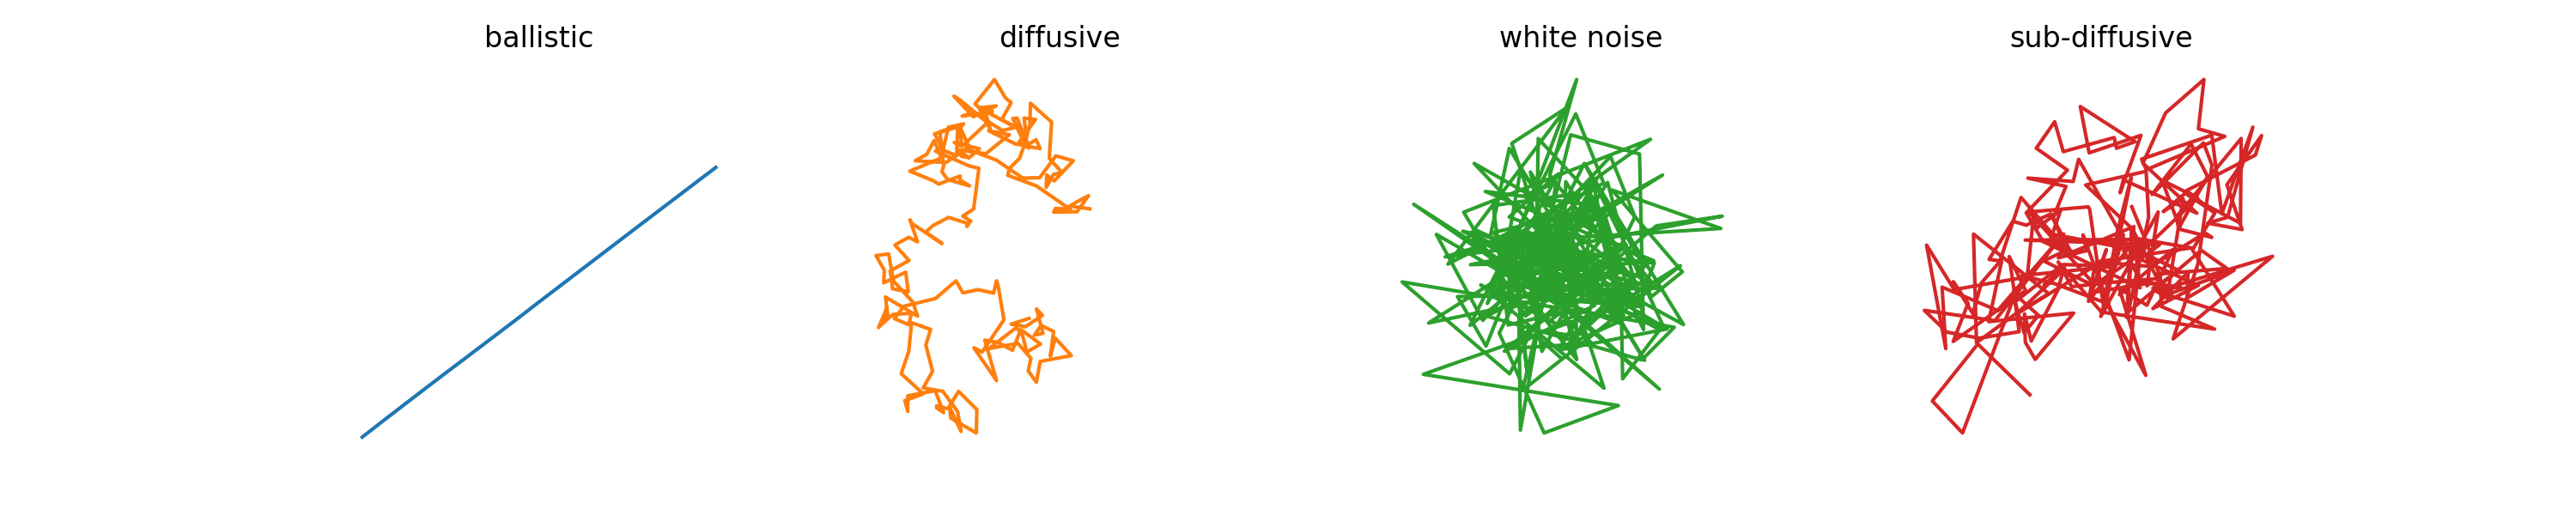

<font size="1">
*: The literature sometimes refers to this as "TA-MSD" (for "time-averaged" MSD), as opposed to keeping the time $t$ fixed (e.g. at the beginning of each trajectory). Since our trajectories do not begin at a definite time anyways, we always use TA-MSD here, dropping the "TA-" for convenience.
</font>

**Question 1**: Check the MSD plot for our data above. What type of motion do we observe? Does that make sense?

## Error terms and the MSD

The reported localizations in our data do not give the exact location of the tracked fluorophore at a specific time. There are two sources of error that we have to consider:
+ **localization error**: because we collect only a finite number of photons for each localization, the precision with which we can pinpoint the central location of the PSF is limited. As hinted above, this is usually modelled as additive Gaussian noise, i.e. we assume that for each localization, we take the true position and add a Gaussian random variable with variance $\sigma$.
+ **motion blur**: to collect photons for each frame, we have to set a finite *exposure time* $\Delta t_\text{expose}$ on the camera. For high-speed, low-intensity acquisitions, it is not uncommon to just expose for the whole duration between two frames, which is the case e.g. with our movie here. So the localizations we get from each frame in the movie are *averaged* over the exposure time.

The effect of motion blur gets stronger the more "constrained" the particle motion is (i.e. the lower the exponent). Consider the two extremes: for ballistic motion, averaging over the exposure time changes nothing, since the particle moves in a straight line either way. For white noise, averaging over any finite exposure time amounts to averaging infinitely many Gaussian random variables, which just yields their mean; so in fact we lose *all* the signal!

Fortunately, we can calculate the effect of motion blur on the observed MSD. The dominant effect is the subtraction of a constant, i.e.
$$
\mathrm{MSD}_\text{motion blurred}(\Delta t) = \mathrm{MSD}_\text{real}(\Delta t) - 2B\,,
$$
with
$$
B = \frac{\mathrm{MSD}_\text{real}(\Delta t_\text{expose})}{(\alpha + 1)(\alpha + 2)}\,.
$$
To derive these formulas (not shown here), we assumed that $\mathrm{MSD}_\text{real}(\Delta t) = \Gamma\Delta t^\alpha$ is a powerlaw with some exponent $\alpha$.

**Question 2: motion blur**. Forgetting about localization error for the time being (i.e. assume $\sigma = 0$), estimate the effect of motion blur (i.e. the constant $B$) from our data. You can assume that $\alpha = 0.5$. How would you correct the MSD curve for this effect? Make a plot showing the raw and corrected curves.

Hints:
+ acquisition for this movie was continuous, i.e. $\Delta t_\text{expose} = 1\text{ frame}$
+ you can use the line  
  ```python
      msd = nl.analysis.MSD(data)
  ```  
  to calculate the ensemble MSD of our data set. Keep in mind that this will of course be $\mathrm{MSD}_\text{motion blurred}$!
+ start by finding an expression for $\mathrm{MSD}_\text{real}(\Delta t_\text{exposed})$ in terms of $\mathrm{MSD}_\text{motion blurred}(\Delta t_\text{exposed})$. Once you have that, you can calculate $B$.

**Question 3: localization error**. How does localization error affect the MSD? As hinted above, a decent model for localization error is to assume that we just add a little bit of white noise to our trajectories. Since the noise is uncorrelated with the real data, the MSDs just add (it is instructive to convince yourself of this by going through the calculation!). We found above that the MSD for white noise is $\mathrm{MSD}(\Delta t) = 2\sigma^2$; since we add noise for both the $x$- and $y$- dimensions, we get another factor of 2, giving rise to
$$
\mathrm{MSD}_\text{with localization error} = \mathrm{MSD}_\text{ideal} + 4\sigma^2\,.
$$

In the section on linking we plotted a histogram of the localization uncertainties reported by ThunderSTORM. Refer to the plot and pick a reasonable consensus value (you can calculate a mean; or just pick something by eye). Correct the MSD curve from Question 2 with this value and add the result to your plot.

### Solution to Questions 2 & 3

Evaluating the top equation at $\Delta t_\text{expose}$ and plugging in the expression for $B$ gives
$$
\mathrm{MSD}_\text{motion blurred}(\Delta t_\text{expose}) = \left[ 1 - \frac{2}{(\alpha+1)(\alpha+2)} \right] \mathrm{MSD}_\text{real}(\Delta t_\text{expose})\,,
$$
which we can rewrite as
$$
\mathrm{MSD}_\text{real}(\Delta t_\text{expose}) = \frac{(\alpha+1)(\alpha+2)}{\alpha^2 + 3\alpha} \mathrm{MSD}_\text{motion blurred}(\Delta t_\text{expose})\,.
$$
Plugging into the equation for $B$, we get
$$
B = \frac{\mathrm{MSD}_\text{motion blurred}(\Delta t_\text{expose})}{\alpha(\alpha+3)}\,.
$$

Now (keeping in mind that $\Delta t_\text{expose} = 1$ frame) we can evaluate this expression.

In [ ]:
# Estimate motion blur
msd = nl.analysis.MSD(data)
a = 0.5

B = msd[1]/(a*(a+3))
print(f" B  = {B:.3g} μm²")

# Localization error
loc_err = 15               # nm (from histogram)
sigma2 = (loc_err*1e-3)**2 # μm²
print(f"4σ² = {4*sigma2:.3g} μm²")

# Make a plot
plt.plot(dt*np.arange(1, len(msd)), msd[1:],
         label='raw',
        )
plt.plot(dt*np.arange(1, len(msd)), msd[1:]+2*B,
         label='motion blur corrected',
        )
plt.plot(dt*np.arange(1, len(msd)), msd[1:]+2*B-4*sigma2,
         label='motion blur and\nlocalization error corrected',
        )

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('lag time [sec]')
plt.ylabel('MSD [μm²]')

plt.show()

Clearly it is important to correctly deal with these two error terms! In our case motion blur is the dominant contribution; in general, either or both might be important.

However: so far we took a pretty casual approach to these corrections. In the next section we will learn about a more principled treatment.

## Parameter inference

How can we learn parameters (such as the anomalous exponent $\alpha$) in a statistically rigorous way?

The literature standard is to take the MSD curve we plotted above, plot a powerlaw (straight line in log-space) with some slope next to it, and report "looks like this or that exponent".

Two points make this approach problematic:
+ the error terms we explored in the previous section distort the MSD curve; the motion blur term actually depends on the parameters of the *true* process, creating a somewhat circular logic (remember that when we explored motion blur above, I just told you to set $\alpha = 0.5$; of course you can't do that in the real world).
+ strongly correlated errors in the MSD curve make simple curve fitting (e.g. least squares) unreliable. Check the MSD curve above: towards the end it does some random things, but it doesn't really "look as noisy as one would expect if all of that was just random fluctuation". This is exactly the effect of correlated errors.

**Question 4: noise in MSD curves**. Randomly select half of the trajectories from our data set and plot the MSD curve of that ensemble. Repeat a few times and plot all the curves on the same plot. Note how the curves diverge quite a lot, even in places where they don't really "look noisy" yet.

Hint: you can use `data.makeSelection(prand=0.5)` to randomly select half the trajectories.

### Solution to Question 4

In [ ]:
for _ in range(5):
    data.makeSelection(prand=0.5)
    msd = nl.analysis.MSD(data)
    plt.plot(dt*np.arange(1, len(msd)), msd[1:])

plt.xscale('log')
plt.yscale('log')
plt.xlabel('lag time [sec]')
plt.ylabel('MSD [μm²]')
plt.title('Noise in MSD curves\nEach curve is ensemble MSD for randomly selected 50% of trajectories')

plt.show()

### So, how do we fit this properly?

Short answer: run the code below. The first cell runs the actual fit, the second cell just prints and plots the results.

In [ ]:
data.makeSelection()
fit = bayesmsd.lib.NPFit(data, motion_blur_f=1.)
fitres = fit.run(show_progress=True)

In [ ]:
print("Fit results:")
for key in sorted(fitres['params']):
    print(f"  {key:>15s} = {fitres['params'][key]}")

# Plot
data.makeSelection()
msd = nl.analysis.MSD(data)
t_plot = np.arange(1, len(msd))
plt.plot(dt*t_plot, msd[1:], label='data')

msd = fit.MSD(fitres['params'], dt=t_plot)
plt.plot(dt*t_plot, msd, color='r', label='fit')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('time [sec]')
plt.ylabel('MSD [μm²]')
plt.title('MSD and its fit')

plt.show()

Before getting into what exactly is happening here, let's do one more thing: the fit above gives us some parameter values, but we do not get error bars. Specifically: do you think the reported exponent is consistent with a Rouse model ($\alpha = 0.5$)? Run the code below to find out!

(*on my laptop this takes about two minutes to run*)

In [ ]:
profiler = bayesmsd.Profiler(fit, conf=0.95)
mci = profiler.find_MCI(show_progress=True)

print("Fit results with 95% credible intervals:")
for key in sorted(mci):
    print(f"  {key:>15s} = {mci[key][0]:.3g} [{mci[key][1][0]:.3g}, {mci[key][1][1]:.3g}]")

Looks like our data is consistent with a Rouse model!* Meaning: $\alpha = 0.5$ is within the 95% credible interval. Note that this credible interval is still pretty broad; remember that we are analyzing data from a single nucleus.

<font size="1">
*: Note that because the Rouse model is pretty simplistic, we don't actually have much of a reason to expect this in a biological system. But it's a fun observation.
</font>

### Huh? What just happened?

We applied some library functions without understanding what they do and got some results that I told you make sense. To understand what's going on, we will have to take a little dive into theory (yay!).

(*we most likely will not have time to go through this during the workshop; if you want more details, come talk to me afterwards!*)

Let's make two fundamental assumptions:

1. **Gaussianity**
   
   The process generating our trajectories has Gaussian statistics. For our scenario here, this means that increments $x(t+\Delta t) - x(t)$ are distributed as Gaussians (normal distributions).
   
2. **Increment stationarity**
   
   The increment correlation function
   $$
   C(\tau_1, \tau_2, t_1, t_2) \equiv \left\langle \left[ x(t_2+\tau_2) - x(t_2) \right]\left[ x(t_1+\tau_1) - x(t_1) \right] \right\rangle
   $$
   does not depend on the absolute times $t_1$ and $t_2$, but only on the difference $\Delta t \equiv t_2-t_1$. We write $C(\tau_1, \tau_2, \Delta t)$.

Note how the expression for the increment correlation function is quite reminiscent of the expression for the MSD $\psi(\Delta t)$:
$$
\psi(\Delta t) \equiv \left\langle \left(x(t+\Delta t) - x(t)\right)^2 \right\rangle\,.
$$
Indeed, by inspection you can see that
$$
\psi(\Delta t) = C(\Delta t, \Delta t, 0)\,.
$$
So once we know the full increment correlation function, we can calculate the MSD as a special case. So far, this is not particularly surprising, since the increment correlation function is the more general object. Interestingly, however, under the assumption of increment stationarity (see above), we can also do the reverse:
$$
C(\tau_1, \tau_2, \Delta t) = \frac{1}{2}\left[ \psi(\Delta t + \tau_2) + \psi(\Delta t - \tau_1) - \psi(\Delta t) - \psi(\Delta t + \tau_2 - \tau_1) \right]\,.
$$

**Question 5**: Prove the relationship above. You can do this by writing $C$ and $\psi$ in terms of expectation values of $x(t)$ and reformulating.

<div class="alert alert-block alert-success">
<em>For an increment stationary process, the full increment correlation is fully determined by the
MSD</em>. This increment correlation function can be viewed as the "second moment"* of the process; so <b>an increment stationary Gaussian process will be fully specified by this second moment, i.e. the MSD</b>.
</div>

This means we have a well-defined probability distribution over trajectories!

<font size="1">
*: technically: second cumulant. But we usually assume zero mean (drift), so the distinction is moot.
</font>

**Question 6**: Write down the probability distribution $P\left(X\mid\psi\right)$ of an increment stationary (and zero mean) Gaussian process with MSD $\psi(\Delta t)$. Here, $X \equiv \left( x(t_1), x(t_2), \ldots, x(t_n) \right)^T$ is the $n$-dimensional vector of positions at times $\left\lbrace t_1, t_2, \ldots, t_n \right\rbrace$.

**Solution to Question 6**

From the trajectory values $X$, we define the $n-1$ successive increments
$$
\Delta X_i \equiv x(t_{i+1}) - x(t_i)\,.
$$
Now, the correlation matrix $\Sigma$ of these increments is given by the increment correlation function and thus the MSD:
\begin{align}
\Sigma_{ij} {}\equiv{}& \left\langle \Delta X_i \Delta X_j \right\rangle \\
{}={}& \left\langle \left[ x(t_{i+1}) - x(t_i) \right]\left[ x(t_{j+1}) - x(t_j) \right] \right\rangle \\
{}\equiv{}& C\left(t_{j+1} - t_j, t_{i+1} - t_i, t_i-t_j\right) \\
{}={}& \frac{1}{2}\left[ \psi(t_{i+1} - t_j) + \psi(t_i - t_{j+1}) - \psi(t_i - t_j) - \psi(t_{i+1} - t_{j+1}) \right]
\end{align}
This gives the correlation matrix; we will furthermore assume that $\left\langle \Delta X_i \right\rangle = 0\,\forall i$, i.e. there is no drift in the particle motion. Then we can immediately write the full distribution over $X$ as the following multivariate Gaussian:
$$
P\left(X\mid\psi\right) = \left|2\pi\Sigma\right|^{-\frac{1}{2}} \exp\left( -\frac{1}{2}\Delta X^T \Sigma^{-1} \Delta X \right)\,.
$$

<div style="text-align: right"> $\square$ </div>

Having an explicit expression for the *distribution over trajectories* $P\left(X\mid \psi\right)$ now allows us to do straight-forward Bayesian statistics with our data. Specifically, Bayes' law here reads
$$
P\left(\psi\mid X\right) = \frac{P\left(X\mid \psi\right) P\left(\psi\right)}{P\left(X\right)}\,.
$$
In this expression, the left hand side $P\left(\psi\mid X\right)$ is the *posterior probability* for the MSD curve $\psi$ given the observed data. On the right hand side, we have the *likelihood function* $P\left(X\mid \psi\right)$ and the *prior* $P\left(\psi\right)$, as well as the *evidence* $P\left(X\right)$. The evidence is independent of $\psi$ and thus serves mostly as normalization constant of the posterior; if we are interested in e.g. a *maximum a posterior* (MAP) estimate of the MSD curve, we can therefore ignore this term for the most part, leaving us with likelihood and prior.

The likelihood function is the center piece of the machinery. We saw in Question 6 how we can evaluate this expression explicitly.

We therefore only need to discuss the prior $P(\psi)$. This is a probability density over "all MSD curves", which is rather ill-defined. So we make this more precise by restricting&mdash;*a priori*&mdash;to MSD curves of certain shapes, like powerlaws or some model-based expression. The parameter space then reduces to a few scalar parameters, which we can usually infer with reasonable degrees of accuracy.

**Example: powerlaw MSDs**. So far in this workshop, we have mostly considered MSDs of the shape
$$
\psi(\Delta t) = \Gamma \Delta t^\alpha\,,
$$
which are parametrized by an exponent $\alpha$ and a prefactor $\Gamma$ (sometimes referred to as "anomalous diffusion constant"). Gaussian processes with MSDs of this shape are known as *fractional Brownian motion* (fBm) and are one of the most popular models in the analysis of stochastic trajectories; to the extent that it is often taken as a given that MSDs should exhibit powerlaw behavior and the "exponent" $\alpha$ is a useful quantity to report. It is worth keeping in mind that this is not necessarily true.

**Example: MSDs beyond simple powerlaws**. Consider two particles on a polymer; we track both and calculate the relative position of one with respect to the other. Under the Rouse model, the MSD of this process is given by two parameters $\Gamma$ und $J$ and has the following form:
$$
\psi(\Delta t) = 2\Gamma\sqrt{\Delta t}\left[1 - \exp\left(-\frac{J^2}{\pi\Gamma^2\Delta t}\right)\right] + 2J \,\mathrm{erfc}\sqrt{\frac{J^2}{\pi\Gamma^2\Delta t}} \,.
$$
Note that from a statistical point of view, this expression is exactly as "complicated" than the powerlaw; both have two parameters to be inferred.

<div style="text-align: right"> $\square$ </div>

Once we settle on a useful parametric expression for the MSD, the Gaussian process likelihood and Bayes' law then allow us to calculate the (unnormalized) posterior, i.e. the probability density over the parameters given the data. Maximizing that expression gives a good point estimate; by exploring the posterior landscape around that maximum, we can give uncertainties on the estimates. These two steps are exactly what the `fit` and `profiler` objects do, respectively, in the code above.

The described approach allows us to "fit MSDs" in a statistically rigorous way. Technically, this statement is actually somewhat misleading: we do not fit anything to the empirical MSD curve we calculate from the data. Instead, we fit a Gaussian process straight to those data; it just so happens that this Gaussian process is parametrized in terms of its MSD, which is thus a useful visualization.

**Note**: This logic also implies that any other second order statistic (e.g. velocity auto-correlation) is either equivalent to or contains less information than the MSD. This is the reason why MSDs are such a central object in trajectory analysis: given Gaussianity and suitable stationarity assumptions, the MSD contains full information about the process.

**More info**: a comprehensive treatment of this logic is presented in Chapter 6 of [my PhD thesis](https://dspace.mit.edu/handle/1721.1/152570). Tutorials, examples, and full API reference for `bayesmsd` are [available at ReadTheDocs](https://bayesmsd.readthedocs.io/en/latest/).

## Trajectory-level heterogeneity

Let's take another look at our empirical MSD plot:

In [ ]:
data.makeSelection()
nl.plot.msd_overview(data, dt=dt, alpha=0.5) # useful shortcut

plt.xlabel('time [sec]')
plt.ylabel('MSD [μm²]')
plt.ylim([1e-4, None])
plt.show()

The MSD curves for the single trajectories (colored lines in the background) look like they all have a similar exponent; the prefactor, however (vertical offset in the log-plot) scatters across one order of magnitude. Is this just noise (we are looking at individual trajectories, after all) or is there actually some heterogeneity here? How could we assess this?

Essentially, we would like to know what our data set would look like, if all the trajectories truly came from the same process. Fortunately, we have full information about this process, since we have the MSD. So we can just sample trajectories homogeneously from this process and cut them to match the real data in length and missing frames. This is what the following code does.

In [ ]:
# Fit MSD of the real data
fit = bayesmsd.lib.NPFit(data, motion_blur_f=1.)
res = fit.run()

# Generate homogeneous control data
control = bayesmsd.gp.generate_dataset_like(data, (fit, res))

# Plot!
fig, axs = plt.subplots(1, 2, figsize=[10, 4], sharex=True, sharey=True)
for ax, dat, title in zip(axs, [data, control], ['real data', 'homogeneous control']):
    dat.makeSelection()
    nl.plot.msd_overview(dat, ax=ax, dt=dt, alpha=0.5)

    ax.set_xlabel('time [sec]')
    ax.set_ylabel('MSD [μm²]')
    ax.set_ylim([1e-4, None])
    ax.set_title(title)

plt.show()

On the right, all trajectories are sampled from the same process. Because we have finite data, the single trajectories still scatter around the ensemble mean / true MSD. However, the scatter is noticeably less than in the real data. We conclude that chromatin motion in the (single!) nucleus in our movie is heterogeneous: some loci move faster than others.

**Question -1**: What makes chromatin loci move faster or slower?